In [3]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

In [0]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


In [5]:
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
# Upload the kaggle credentials 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Reading the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Credit Fraud detector/creditcard.csv')

In [93]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


In [11]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
# Finding the null values
df.isnull().sum().max()

0

Here we can see that there aren't any null values present in the dataset.

In [13]:
print('No Frauds cases are', round(df['Class'].value_counts()[0]/len(df) * 100,2), ' % of the dataset')
print('Fraud cases are', round(df['Class'].value_counts()[1]/len(df)* 100,2), '% of the dataset')

No Frauds cases are 99.83  % of the dataset
Fraud cases are 0.17 % of the dataset


Our dataset is imbalanced. Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distribution \n ( 0: No Fraud || 1: Fraud )')

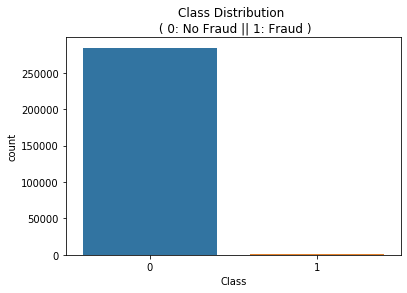

In [14]:
sns.countplot('Class', data=df)
plt.title('Class Distribution \n ( 0: No Fraud || 1: Fraud )')

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed .

 **Scaling and Distributing**

In this phase of our kernel, we will first scale the columns comprise of Time and Amount . Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

**Why do we create a sub-Sample?**

In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe will cause the following issues:

**Overfitting:** Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.

**Wrong Correlations:** Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

**Summary:**

* **Scaled amount** and **scaled time** are the columns with scaled values.

* There are **492 cases** of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe.

* We concat the 492 cases of fraud and non fraud, **creating a new sub-sample**.

In [0]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [0]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [0]:
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [19]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
119424,-1.426928,0.646295,1.210540,-1.622925,0.464642,-0.329375,0.756250,-0.173641,0.300248,0.377678,0.772219,0.721584,0.849654,-0.464849,-0.106549,0.906259,-1.417230,0.245791,-0.110548,0.256725,-0.241250,-0.168560,-0.104400,-0.438854,-0.128617,0.730537,0.240526,0.094284,0,0.320129,-0.108707
130766,1.266466,0.119198,0.063084,0.094105,-0.387478,-1.318295,0.313789,-0.297770,-0.007626,-0.131979,-0.223279,0.051053,-0.381407,0.509950,0.898774,0.140102,-0.180025,-0.954529,0.278964,-0.064368,-0.438326,-1.376137,0.197891,0.390202,0.080802,0.621842,-0.107067,0.005933,0,0.041082,-0.061855
209393,1.848171,-0.394443,-1.309342,0.319922,0.435563,0.363143,-0.019238,0.130473,0.653883,-0.087315,-0.261873,0.412397,-0.603532,0.450844,0.661931,-1.161018,0.725170,-2.253485,-0.940613,-0.284343,-0.146093,-0.250242,0.342920,-1.031721,-0.455072,0.371857,-0.031098,-0.069117,0,0.296234,0.620872
130787,-2.006545,1.401371,0.322691,-0.809995,-2.100752,-0.880335,-1.501685,1.655341,0.797287,-1.857464,-1.227315,0.788471,-0.284886,1.072470,1.297698,-0.333280,0.777008,0.640860,1.355952,-0.531740,0.323980,0.499910,0.106163,0.400654,-0.409232,-0.720548,-0.626920,-0.131381,0,-0.293440,-0.061796
59510,-2.101431,0.822359,0.342028,-0.592551,1.344203,4.774187,0.214765,1.215894,1.024100,-0.223688,-1.294940,0.344891,-0.513716,-0.917540,-2.213358,-0.323495,-0.208014,-0.405269,0.409589,-0.167738,-0.582057,-1.132400,-0.329672,1.002529,0.722509,-0.647231,-0.215014,-0.171547,0,1.812478,-0.420834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,-0.296536,0.069643,1.933851,-1.768341,-0.948129,-0.654008,0.122539,0.001802,1.374633,-1.702838,-0.524167,0.928265,0.655836,-0.589855,0.599536,-0.703701,0.050749,0.012021,1.022621,0.093092,0.027577,0.306806,-0.083224,0.461560,-0.008733,-0.080160,0.066619,0.035464,0,0.251380,-0.669122
198402,-0.982372,-5.748822,-2.686138,0.298864,-1.978157,0.362678,1.403137,-0.328884,1.533858,-1.116532,-1.380019,-0.385912,-0.737084,0.566291,1.646648,0.733758,-0.598702,0.358195,-0.031577,3.039453,0.728846,-1.501121,-1.022508,0.080748,-1.175581,0.181092,-0.351382,0.228181,0,22.049885,0.561367
82491,1.231961,-0.434463,-0.353181,-0.312596,1.433186,3.956628,-1.201919,1.071643,0.797960,-0.181066,-0.505376,0.268831,0.001655,-0.266008,0.387423,0.489388,-0.674259,0.209296,0.331169,0.028835,-0.143435,-0.376046,-0.006577,1.039655,0.413009,0.331772,0.018791,0.020935,0,-0.146720,-0.296878
40288,-1.559919,0.958838,1.967461,-0.653798,0.176069,-0.308582,0.352582,0.675260,-0.878269,-1.230054,1.356582,1.191494,0.158586,0.507850,-0.533924,0.862093,-0.889977,-0.235803,-2.027376,-0.265553,0.020369,-0.327248,-0.109644,0.173933,0.349467,-0.868584,-0.086520,-0.045075,0,-0.056033,-0.523021


**Splitting the Data (Original DataFrame)**

Before proceeding with the **Random UnderSampling technique** we have to separate the orginal dataframe. **Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.** The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

Train: [ 55832  56053  56239 ... 284804 284805 284806] Test: [    0     1     2 ... 56962 56963 56964]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 55832  56053  56239 ... 113930 113931 113932]
Train: [     0      1      2 ... 284804 284805 284806] Test: [111437 111596 111895 ... 170906 170907 170908]
Train: [     0      1      2 ... 284804 284805 284806] Test: [156516 157423 158213 ... 227848 227849 227850]
Train: [     0      1      2 ... 227848 227849 227850] Test: [224257 225002 225016 ... 284804 284805 284806]


**Random Under-Sampling:**


In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more **balanced dataset** and thus avoiding our models to overfitting.

Steps:
The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)

Once we determine how many instances are considered **fraud transactions** (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.

After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to **shuffle the data** to see if our models can maintain a certain accuracy everytime we run this script.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of **information loss** (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

In [21]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
31864,1.234139,-0.943517,0.695706,-1.339927,-1.509932,-0.613180,-0.797182,-0.034444,0.574644,-0.304890,-0.159530,0.672210,0.291893,-0.170555,1.183503,-2.542970,0.575894,0.992010,-0.705468,-0.487586,-0.156467,0.248959,-0.058356,0.419196,0.513941,-0.490566,0.114715,0.038206,0,0.278768,-0.565655
105178,1.140431,1.134243,-1.429455,2.012226,0.622800,-1.152923,0.221159,0.037372,0.034486,-1.879644,2.191665,-0.487850,-1.757137,-4.461051,-0.402884,1.410917,3.619251,2.284927,-0.443999,-0.099712,-0.367136,-0.891627,-0.160578,-0.108326,0.668374,-0.352393,0.071993,0.113684,1,-0.293440,-0.179725
254065,2.022987,-0.660033,-1.180740,0.508635,-0.309437,-0.076935,-0.477445,0.010529,-0.646972,1.241020,0.326550,0.112388,-0.803092,0.500365,-0.654129,-1.532157,-0.343506,1.922784,-1.057871,-0.653659,0.012387,0.566543,0.028840,0.666241,0.225619,-0.362968,0.023787,-0.047758,0,0.167680,0.844359
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,3.045204,-0.942563
50537,-0.234922,0.355413,1.972183,-1.255593,-0.681387,-0.665732,0.059110,-0.003153,1.122451,-1.481246,-0.473852,0.922184,0.913514,-0.499350,0.933898,-0.560472,-0.207707,0.380542,0.574336,-0.003469,0.220670,0.912107,-0.286338,0.451208,0.188315,-0.531846,0.123185,0.039581,1,-0.293440,-0.471810


**Equally Distributing and Correlating:**

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


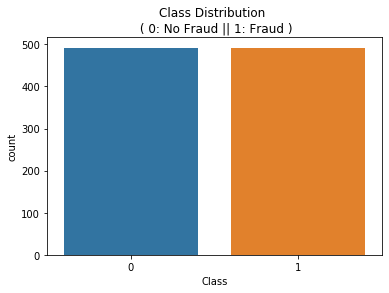

In [23]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Class Distribution \n ( 0: No Fraud || 1: Fraud )')
plt.show()

**Correlation Matrices**

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

**Summary and Explanation:**

**Negative Correlations:** V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

**Positive Correlations: **V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

**BoxPlots:** We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

**Note:** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

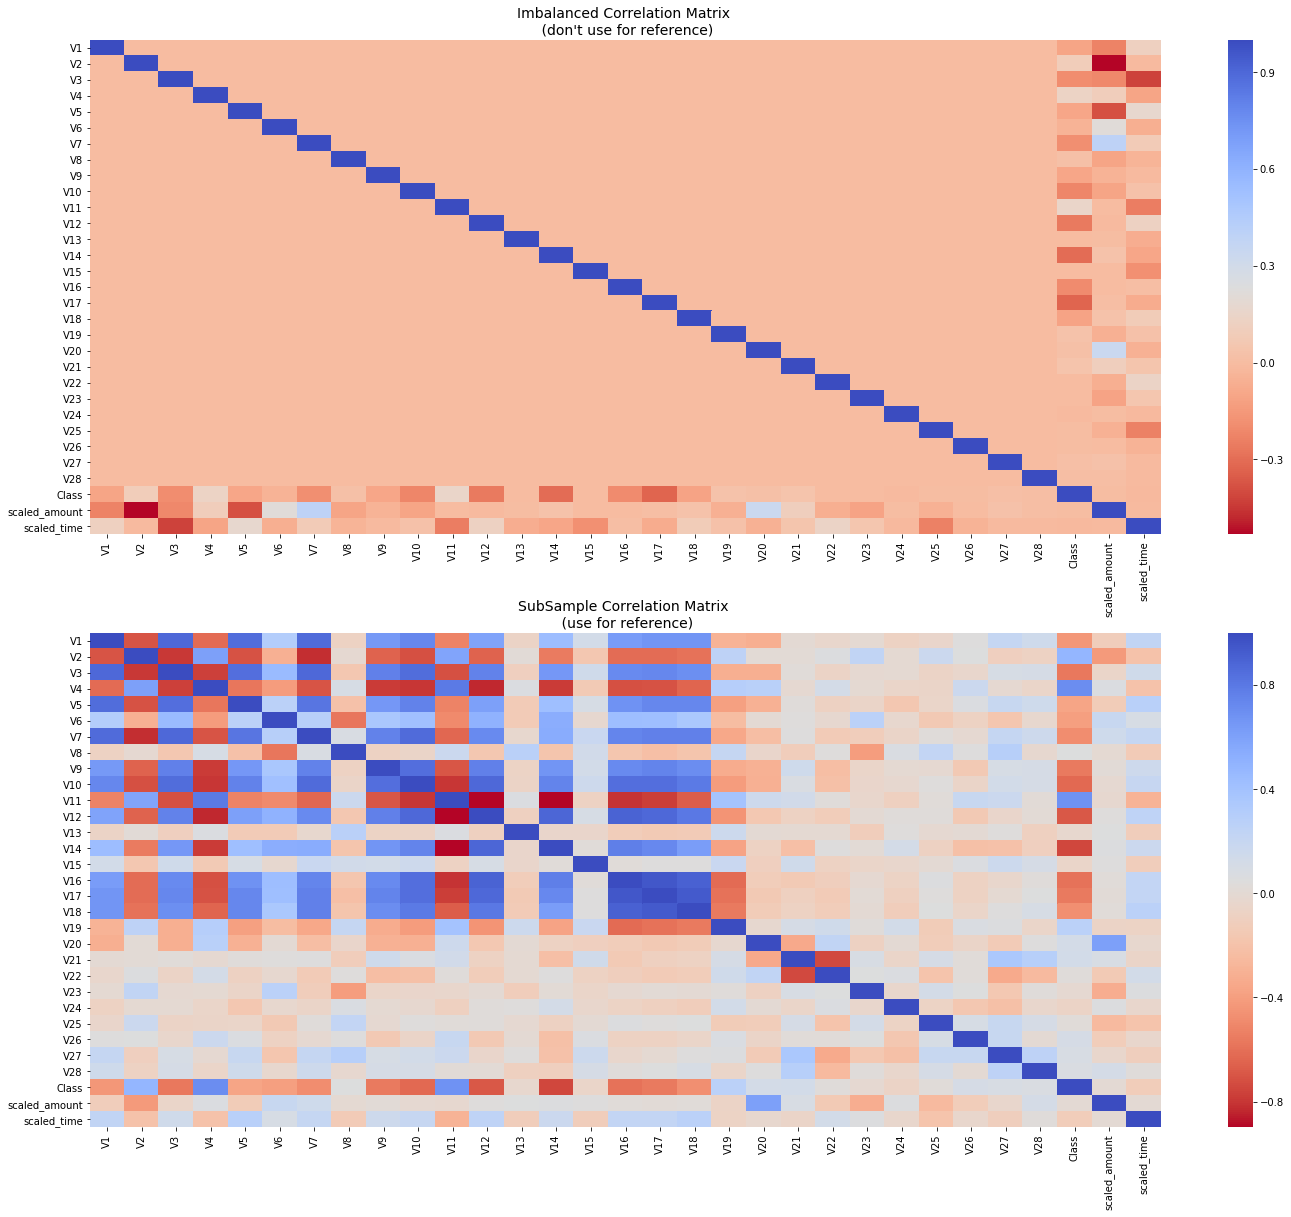

In [25]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

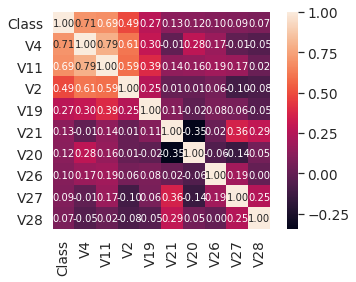

In [30]:
k = 10 #number of variables for heatmap
cols = sub_sample_corr.nlargest(k, 'Class')['Class'].index
cm = np.corrcoef(new_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

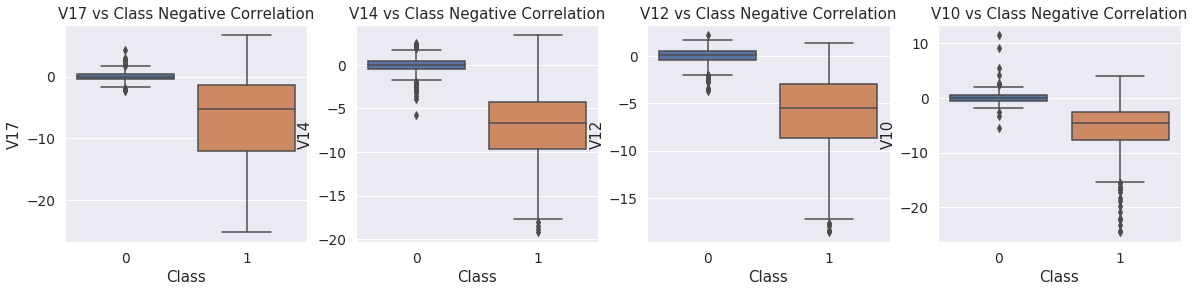

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df,  ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df,  ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

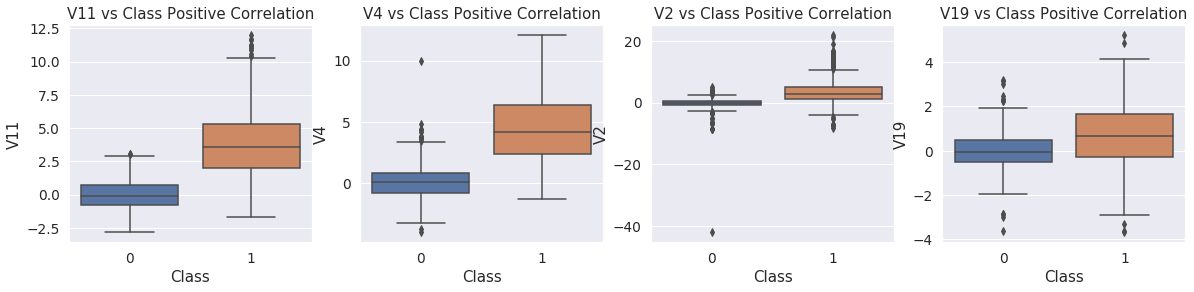

In [34]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df,  ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df,  ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df,  ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df,  ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

**Anomaly Detection:**


Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.

**Interquartile Range Method:**

**Interquartile Range (IQR):** We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.

**Boxplots:** Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

**Outlier Removal Tradeoff:**
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.

**The Tradeoff:** The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

**Summary:**

**Visualize Distributions:** We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10.

**Determining the threshold: **After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold).

**Conditional Dropping:** Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed.

**Boxplot Representation:** Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

**Note:** After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.

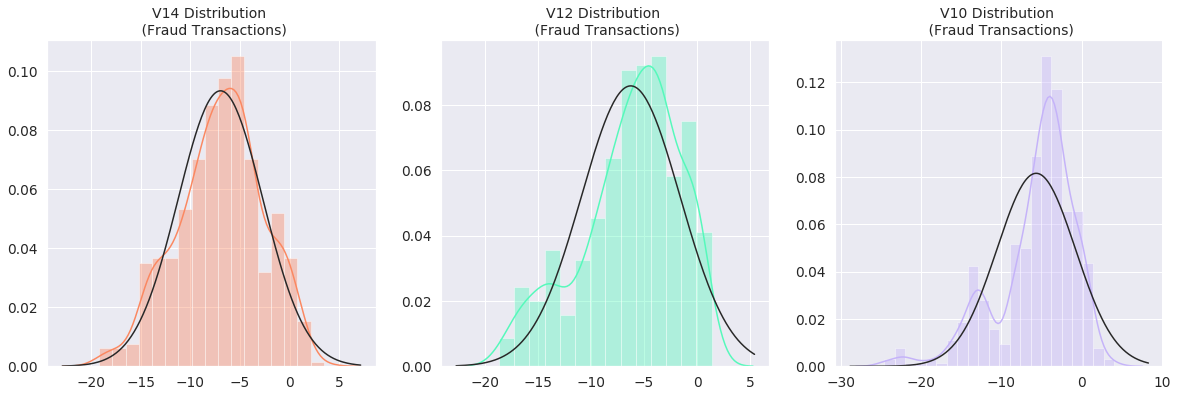

In [35]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [36]:
 # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.4937733551053, -18.8220867423816, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.553697009645802, -18.4311310279993, -18.683714633344298, -18.047596570821604]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-16.2556117491401, -

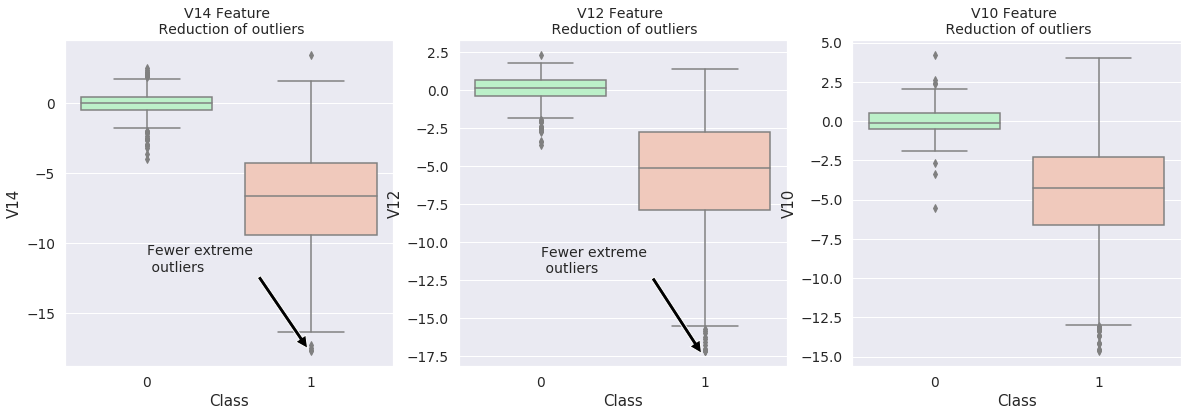

In [37]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

**Dimensionality Reduction and Clustering:**

**Summary:**

* t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.

* Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)

* This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

In [38]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.5 s
PCA took 0.035 s
Truncated SVD took 0.0063 s


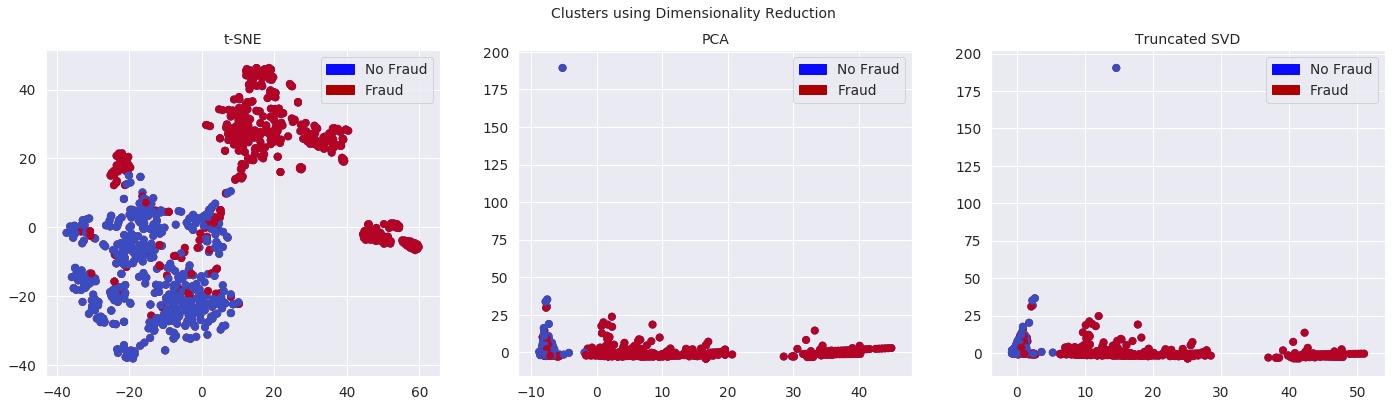

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()


**Classifiers (UnderSampling):**

In this section we will train four types of classifiers and decide which classifier will be more effective in detecting **fraud transactions**. Before we have to split our data into training and testing sets and separate the features from the labels.

**Summary:**

**Logistic Regression** classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)

**GridSearchCV** is used to determine the paremeters that gives the best predictive score for the classifiers.

Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates **fraud** and **non-fraud** transactions.

**Learning Curves:**
* The **wider the gap** between the training score and the cross validation score, the more likely your model is **overfitting (high variance).**
* If the score is low in both training and cross-validation sets this is an indication that our model is **underfitting (high bias)**
* **Logistic Regression Classifier** shows the best score in both training and cross-validating sets.

In [0]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [0]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [0]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [44]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 88.0 % accuracy score


In [0]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [46]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.12%
Knears Neighbors Cross Validation Score 92.99%
Support Vector Classifier Cross Validation Score 93.65%
DecisionTree Classifier Cross Validation Score 91.12%


In [47]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 52125  52182  53365 ... 284804 284805 284806] Test: [    0     1     2 ... 56971 56972 56973]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 52125  52182  53365 ... 114143 114503 114522]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113921 113922 113923 ... 170886 170887 170888]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168452 168936 169232 ... 227851 227852 227853]
Train: [     0      1      2 ... 227851 227852 227853] Test: [224253 224728 224782 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [0]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

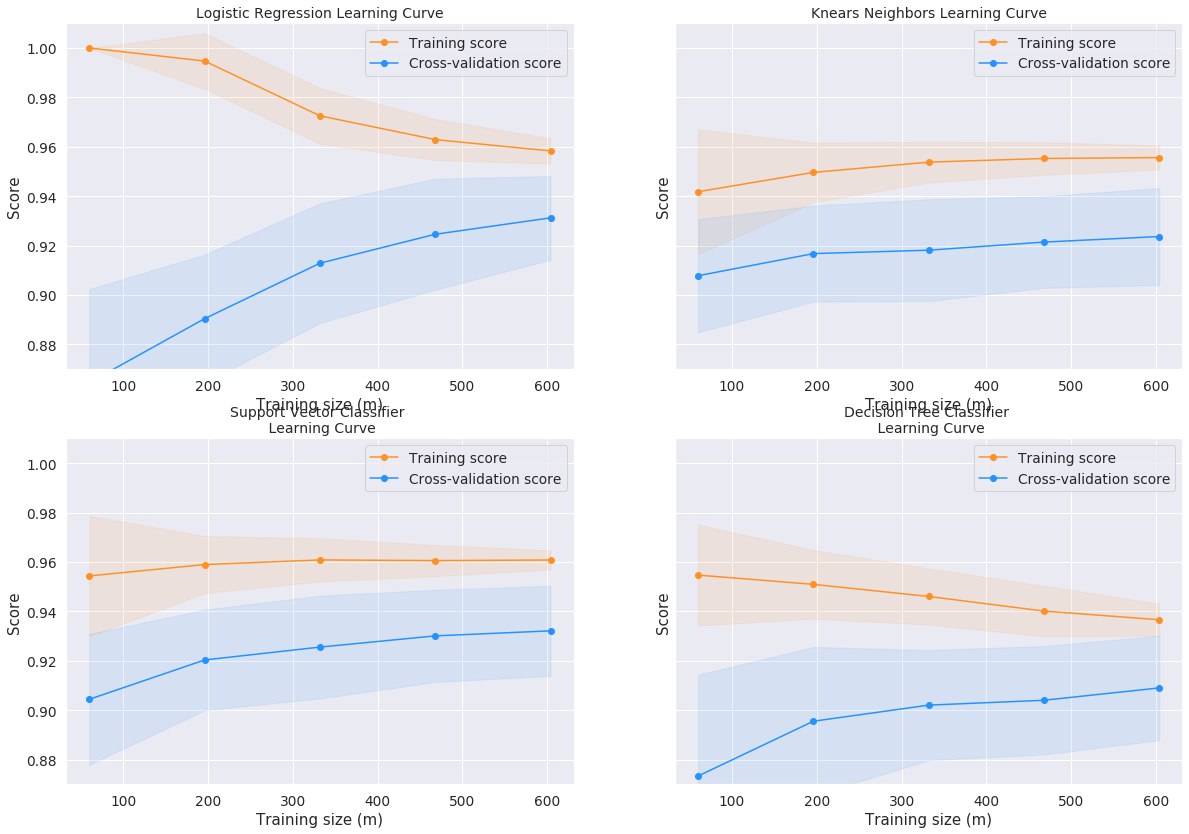

In [49]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [0]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [51]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9645082956682856
KNears Neighbors:  0.927521686645518
Support Vector Classifier:  0.971793324162713
Decision Tree Classifier:  0.9089511804834228


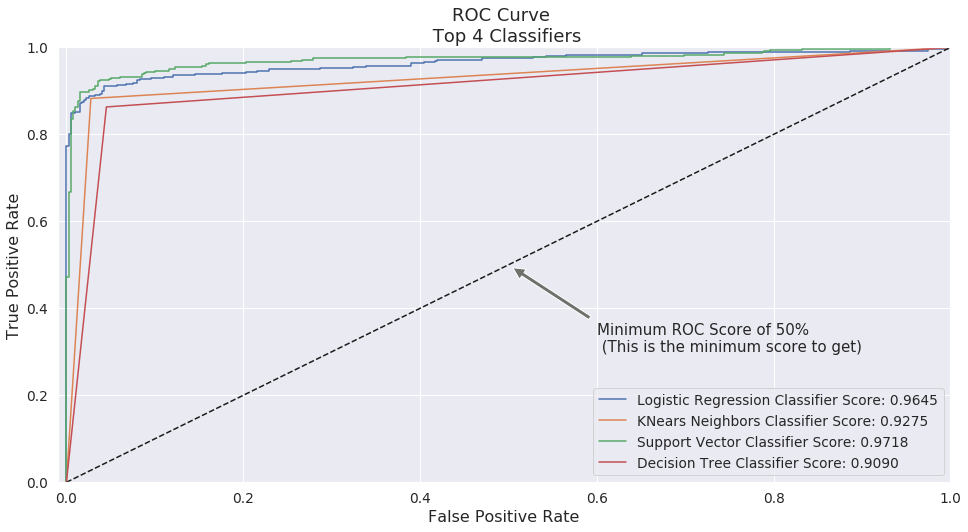

In [52]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()


**A Deeper Look into LogisticRegression:**

**Terms:**

**True Positives:** Correctly Classified Fraud Transactions.
**False Positives:** Incorrectly Classified Fraud Transactions.

**True Negative:** Correctly Classified Non-Fraud Transactions.
**False Negative:** Incorrectly Classified Non-Fraud Transactions.

**Precision:** True Positives/(True Positives + False Positives)

**Recall:** True Positives/(True Positives + False Negatives)

Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.

**Precision/Recall Tradeoff:** The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect.

**Summary:**
Precision starts to descend between 0.90 and 0.92 nevertheless, our precision score is still pretty high and still we have a descent recall score.

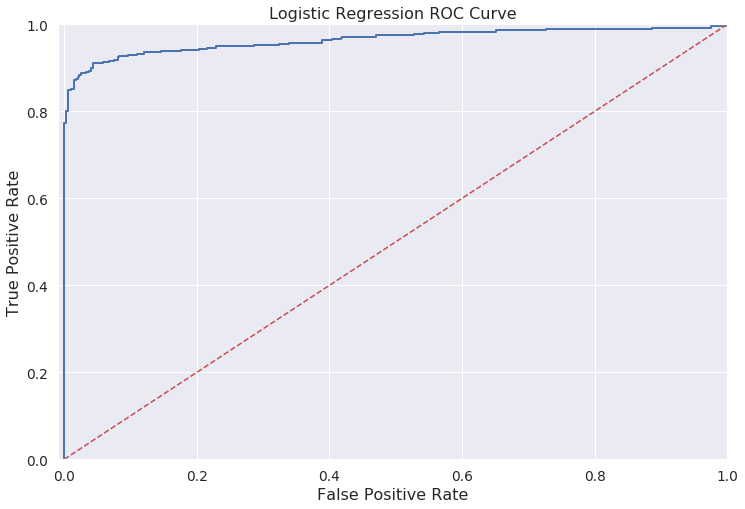

In [53]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [0]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [55]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.95
Precision Score: 0.62
F1 Score: 0.75
Accuracy Score: 0.70
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.47
Precision Score: 0.00
Recall Score: 0.50
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [60]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

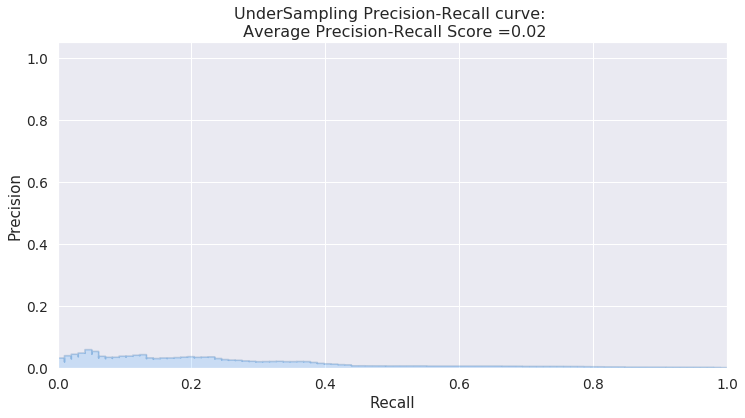

In [61]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

**SMOTE Technique (Over-Sampling):**

* SMOTE stands for **Synthetic Minority Over-sampling Technique.**

* Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

**Understanding SMOTE:**

* **Solving the Class Imbalance:** SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

* **Location of the synthetic points:** SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

* **Final Effect:** More information is retained since we didn't have to delete any rows unlike in random undersampling.

* **Accuracy || Time Tradeoff:** Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

**Cross Validation Overfitting Mistake:**

**Overfitting during Cross Validation:**

* In our undersample analysis there is  a common mistake I made. If you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem.

* As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process.

* As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.


In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9740350724712087
precision: 0.057059031978587416
recall: 0.8986043492372607
f1: 0.10725664528572076
---------------------------------------------------------------------------------------------------------------------------------------


In [63]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     56863
       Fraud       0.06      0.95      0.10        98

    accuracy                           0.97     56961
   macro avg       0.53      0.96      0.55     56961
weighted avg       1.00      0.97      0.98     56961



In [0]:
y_score = best_est.decision_function(original_Xtest)

In [65]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.77


**Test Data with Logistic Regression:**

**Confusion Matrix:**
**Positive/Negative:** Type of Class (label) ["No", "Yes"] **True/False:** Correctly or Incorrectly classified by the model.


**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class.


**False Negatives (Top-Right Square):** This is the number of **incorrectly **classifications of the "No"(No Fraud Detected) class.


**False Positives (Bottom-Left Square):** This is the number of **incorrectly **classifications of the "Yes" (Fraud Detected) class


**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.

**Summary:¶**

**Random UnderSampling:** We will evaluate the final performance of the classification models in the random undersampling subset. Keep in mind that this is not the data from the original dataframe.

**Classification Models:** The models that performed the best were **logistic regression** and **support vector classifier (SVM)**

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.77')

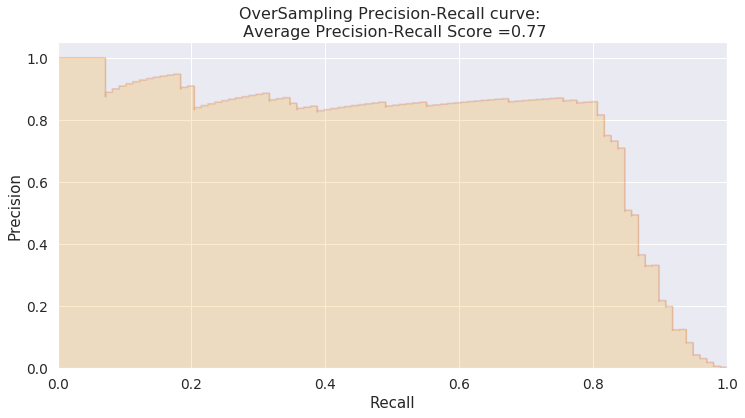

In [67]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [0]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [69]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :6.786969184875488 sec


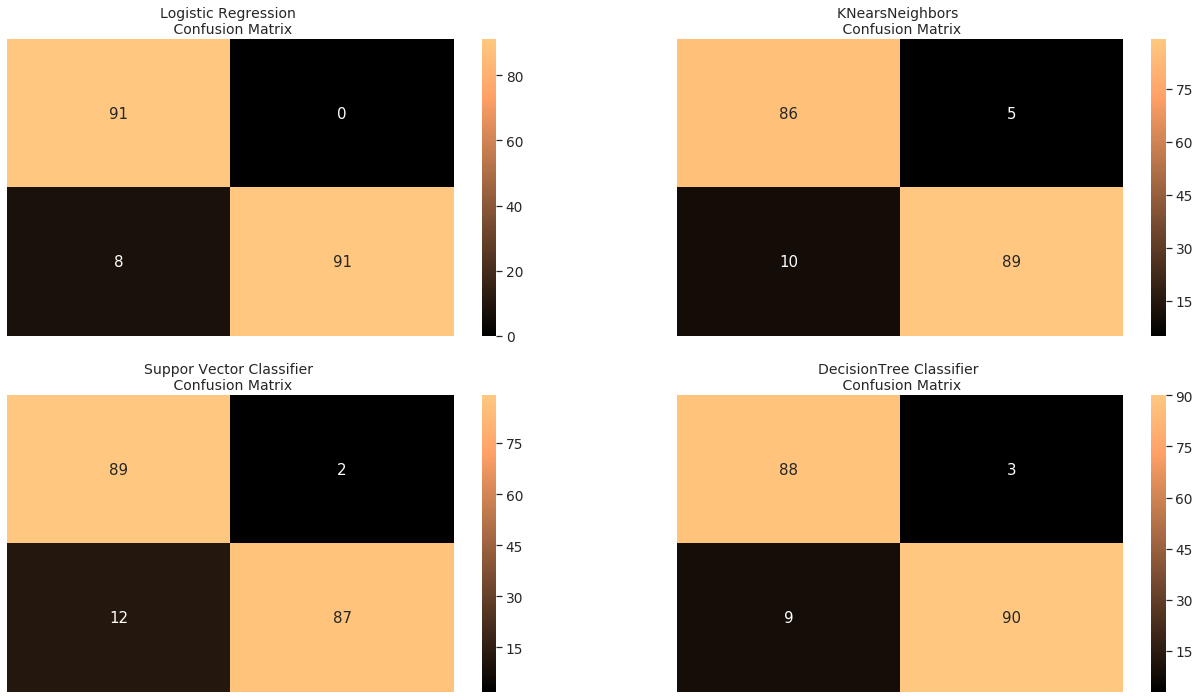

In [70]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()


In [71]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        91
           1       1.00      0.92      0.96        99

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        91
           1       0.95      0.90      0.92        99

    accuracy                           0.92       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.92      0.92      0.92       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        91
           1       0.98      0.88      0.93        99

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted

In [72]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.957895
1,Oversampling (SMOTE),0.972033


**Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):**

In this section we will implement a simple Neural Network (with one hidden layer) in order to see which of the two logistic regressions models we implemented in the (undersample or oversample(SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions.

**Our Main Goal:**

Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Why not only focus on fraud? Imagine you were a cardholder and after you purchased an item your card gets blocked because the bank's algorithm thought your purchase was a fraud. That's why we shouldn't emphasize only in detecting fraud cases but we should also emphasize correctly categorizing non-fraud transactions.

**The Confusion Matrix:**
Here is again, how the confusion matrix works:

**Upper Left Square**: The amount of **correctly** classified by our model of no fraud transactions.

**Upper Right Square:** The amount of **incorrectly** classified transactions as fraud cases, but the actual label is no fraud .

**Lower Left Square:** The amount of **incorrectly** classified transactions as no fraud cases, but the actual label is fraud .

**Lower Right Square:** The amount of **correctly** classified by our model of fraud transactions.

**Summary (Keras || Random UnderSampling):**

**Dataset:** In this final phase of testing we will fit this model in both the random undersampled subset and oversampled dataset (SMOTE) in order to predict the final result using the original dataframe testing data.

**Neural Network Structure:** As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud).

**Other characteristics:** The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.)

In [73]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [74]:
undersample_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [75]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 604 samples, validate on 152 samples
Epoch 1/20





 - 1s - loss: 0.6720 - acc: 0.5844 - val_loss: 0.5094 - val_acc: 0.7171
Epoch 2/20
 - 0s - loss: 0.3523 - acc: 0.8709 - val_loss: 0.3607 - val_acc: 0.8684
Epoch 3/20
 - 0s - loss: 0.2649 - acc: 0.9172 - val_loss: 0.2930 - val_acc: 0.9013
Epoch 4/20
 - 0s - loss: 0.2197 - acc: 0.9288 - val_loss: 0.2594 - val_acc: 0.8947
Epoch 5/20
 - 0s - loss: 0.1958 - acc: 0.9371 - val_loss: 0.2330 - val_acc: 0.9013
Epoch 6/20
 - 0s - loss: 0.1682 - acc: 0.9503 - val_loss: 0.2244 - val_acc: 0.9211
Epoch 7/20
 - 0s - loss: 0.1528 - acc: 0.9503 - val_loss: 0.2183 - val_acc: 0.9211
Epoch 8/20
 - 0s - loss: 0.1424 - acc: 0.9553 - val_loss: 0.2142 - val_acc: 0.9211
Epoch 9/20
 - 0s - loss: 0.1332 - acc: 0.9503 - val_loss: 0.2112 - val_acc: 0.9211
Epoch 10/20
 - 0s - loss: 0.1261 - acc: 0.9536 - val_loss: 0.2082 - val_acc: 0.9211
Epoch 11/20
 - 0s - l

In [0]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [0]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [0]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55159  1704]
 [    3    95]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


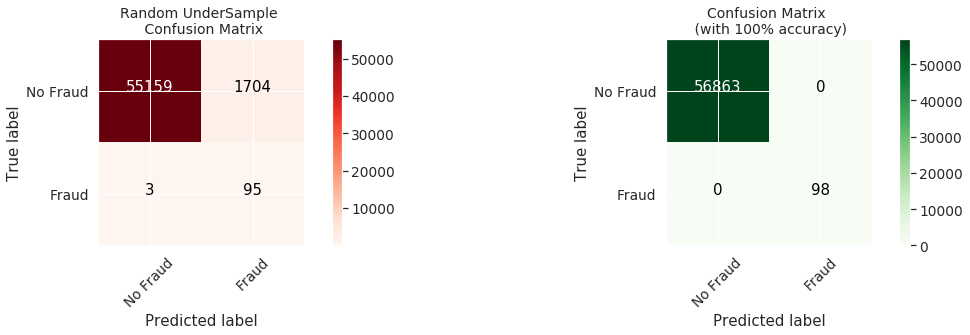

In [80]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Keras || OverSampling (SMOTE)

In [0]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [0]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 3s - loss: 0.0622 - acc: 0.9791 - val_loss: 0.0203 - val_acc: 0.9965
Epoch 2/20
 - 2s - loss: 0.0139 - acc: 0.9969 - val_loss: 0.0052 - val_acc: 0.9996
Epoch 3/20
 - 2s - loss: 0.0082 - acc: 0.9984 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 4/20
 - 2s - loss: 0.0062 - acc: 0.9988 - val_loss: 0.0033 - val_acc: 0.9998
Epoch 5/20
 - 2s - loss: 0.0050 - acc: 0.9992 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 6/20
 - 2s - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 7/20
 - 2s - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 8/20
 - 2s - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 9/20
 - 2s - loss: 0.0033 - acc: 0.9995 - val_loss: 6.4752e-04 - val_acc: 1.0000
Epoch 10/20
 - 2s - loss: 0.0028 - acc: 0.9996 - val_loss: 7.2661e-04 - val_acc: 1.0000
Epoch 11/20
 - 2s - loss: 0.0028 - acc: 0.9996 - val_loss: 5.6723e-04 - val_acc: 1.0000
Epoch 12/20
 - 2s - lo

In [0]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [0]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56831    32]
 [   14    84]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


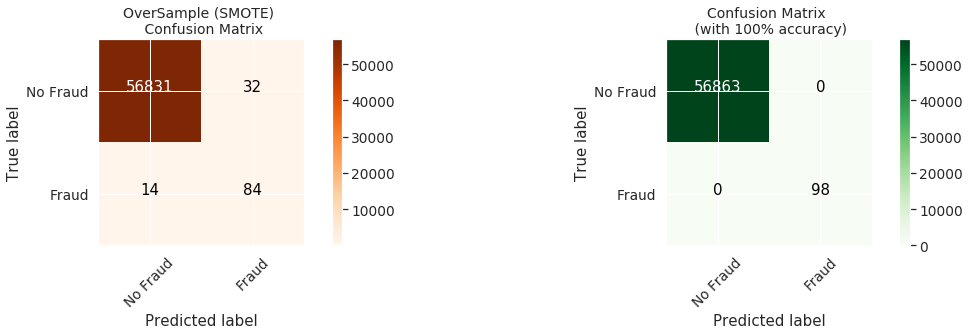

In [86]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

**Conclusion:**

Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase. The next step of this analysis will be to do an outlier removal on our oversample dataset and see if our accuracy in the test set improves.
